In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

td = pd.read_csv('titanic-data.csv')
td.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 问题1：船上乘客的生还率和哪些因素密切相关？

## 数据清理：

经过观察数据，发现跟问题密切相关的列（Survived）比较规整，没有非法值和空值。其他列的数据出了极个别cell有空值外，整体也是比较规整的。所以这里没有做单独的数据清洗操作，只是在针对各列做统计计算前，会使用dropna来去除空值，而且这个清洗操作会封装在统一调用的函数中。

## 公共计算逻辑抽象
下面构造了两个函数，这两个函数后续都有频繁的调用

* check_diff：在特定过滤条件下，计算指定列的各个值之间的占比
* check_hist：在特定过滤条件下，绘制指定列的的直方图

***

### *先看看生还率和性别之间的关系*

从下面的数据可以看出男性幸存者的比例明显偏小 男性人数占到了所有乘客的64.8%，但在幸存者中男性只占比31.9%

In [18]:
def check_diff(df, filter_series, col_name, kv):
    df2 = df
    if filter_series is not None:
        df2 = df[filter_series]
    one_col = df2[col_name]
    total_count = one_col.size
    msgs = []
    for key in kv:
        percent = 1.0*one_col[one_col==key].size / total_count
        msgs.append('%s: %f'%(kv[key], percent))
    print " ; ".join(msgs)

check_diff(td, None, 'Sex', {'male':'男性占比', 'female':'女性占比'})
check_diff(td, None, 'Survived', {0:'不在', 1:'幸存'})
check_diff(td, td.Survived==1, 'Sex', {'male':'幸存者中男性占比', 'female':'幸存者中女性占比'})

男性占比: 0.647587 ; 女性占比: 0.352413
不在: 0.616162 ; 幸存: 0.383838
幸存者中男性占比: 0.318713 ; 幸存者中女性占比: 0.681287


### *看一下生还率和年龄之间的关系*

从下面叠加的直方图中，可以看出只有0～8岁年龄段的乘客生还比例明显高于其他年龄段，除此之外的各年龄段生还比例没有显著差别。

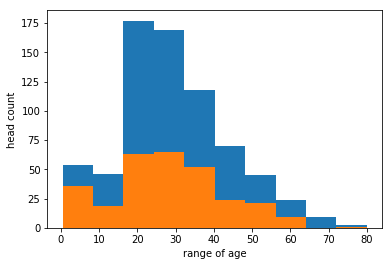

In [26]:
def check_hist(df, filter_series, col_name, bin_size=None):
    df2 = df
    if filter_series is not None:
        df2 = df[filter_series]
    if bin_size is not None:
        plt.hist(df2[col_name].dropna(), bins=bin_size)
    else:
        plt.hist(df2[col_name].dropna())
            

check_hist(td, None, "Age")
check_hist(td, td.Survived==1, "Age")
plt.ylabel("head count")
plt.xlabel("range of age")
plt.show()

### *看一下生还率和pclass（舱位等级）的关系*

从下面的直方图中可以看出，1等舱到3等舱，生还比例逐渐在减小。所以高等级舱位的乘客的生还概率明显比较大。

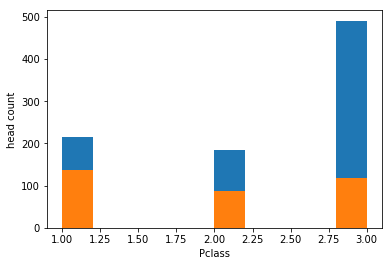

In [27]:
check_hist(td, None, "Pclass")
check_hist(td, td.Survived==1, "Pclass")
plt.ylabel("head count")
plt.xlabel("Pclass")
plt.show()

### *看一下生还率和SibSp（同船兄弟姐妹或配偶个数）之间的关系*

（这里使用了上面的函数check_hist）

全体乘客和生还乘客的SibSp个数分布趋势相近，因此推测SibSp和是否生还关系不大

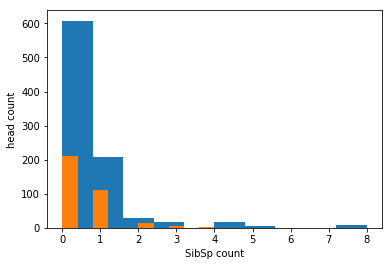

In [29]:
check_hist(td, None, "SibSp")
check_hist(td, td.Survived==1, "SibSp")
plt.ylabel("head count")
plt.xlabel("SibSp count")
plt.show()

### *看一下生还率和parch（同船父母或子女个数）之间的关系*

全体乘客和生还乘客的Parch个数分布趋势相近，因此推测Parch和是否生还关系不大

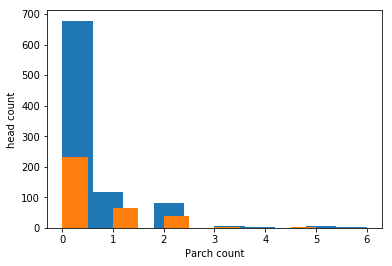

In [14]:
check_hist(td, None, "Parch")
check_hist(td, td.Survived==1, "Parch")
plt.ylabel("head count")
plt.xlabel("Parch count")
plt.show()

### *看一下生还率和Parch与SibSp综合起来是否相关*

全体乘客和生还乘客的分布依然相近，所以Parch和SibSp综合起来看也和是否生还关系不大

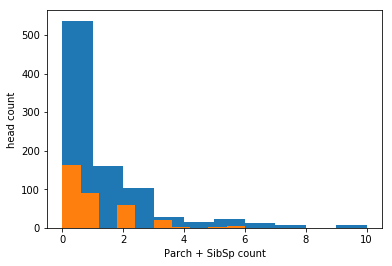

In [15]:
#增加一列'ParchPlusSibSp'，反映'Parch'和'SibSp'之和
td['ParchPlusSibSp'] = td['Parch']+td['SibSp']
check_hist(td, None, "ParchPlusSibSp")
check_hist(td, td.Survived==1, "ParchPlusSibSp")
plt.ylabel("head count")
plt.xlabel("Parch + SibSp count")
plt.show()


***

# 结论
## 综上，可以得出结论，生还概率跟性别、舱位等级有着显著的相关性；另外，幼龄段（0～8岁）的乘客有着明显较高的生还概率

为了进一步验证结论，下面代码计算出了1，2，3等舱的男、女乘客总数和生还比例，这里把乘客总数列出来有助于观察会不会由于样本总数过少，造成比例计算失真。

从这组数字可以看出
>* 1，2等舱的女乘客的生还比例非常高（96.8%，92.1%），且1等舱高于2等舱
* 1，2等舱女乘客的生还比例显著高于3等舱女乘客（50%）
* 1，2，3等舱男乘客的生还比例同女乘客相比都比较低
* 只是1等舱男乘客的生还比例（36.9%）比较显著高于其他舱位的男乘客

In [35]:
for sex in ('female', 'male'):
    for pclass in range(1,4):
        filter = (td['Pclass']==pclass) & (td['Sex']==sex)
        print "%d等舱的%s乘客总数：%d" % (pclass, sex, td[filter].shape[0])
        check_diff(td, filter, 'Survived', {0:'不在', 1:'幸存'})
        print "*"*50
    print "\n"*2

1等舱的female乘客总数：94
不在: 0.031915 ; 幸存: 0.968085
**************************************************
2等舱的female乘客总数：76
不在: 0.078947 ; 幸存: 0.921053
**************************************************
3等舱的female乘客总数：144
不在: 0.500000 ; 幸存: 0.500000
**************************************************



1等舱的male乘客总数：122
不在: 0.631148 ; 幸存: 0.368852
**************************************************
2等舱的male乘客总数：108
不在: 0.842593 ; 幸存: 0.157407
**************************************************
3等舱的male乘客总数：347
不在: 0.864553 ; 幸存: 0.135447
**************************************************





## 以上结论只是根据项目提供的单一数据表计算观察得出，这个表中的数据只有较少的维度，很多其他可能会影响生还的因素没有反映出来。因此，这只能作为一个暂时性的结论，更全面的结论需要基于更丰富的数据才能得出。

# 问题2: 船票定价的影响因素
## 数据清洗

去除数据列Fare中的负值和零值

In [8]:
td2 = td[td['Fare']>0]

print td.shape, td2.shape

(891, 12) (876, 12)
